In [1]:
!pip install imbalanced-learn

# Imbalanced Data Learning

This week we will focus on a specific imbalanced data problem, and see how the different approaches behave in it.

#### First, we will create some random data

In our data there will be 9 majority classes for each minority class (you can change it by adjusting the `weights` parameter below).
You can also add more samples - I only added 100 for illustrative purposes - but you can add more by changing the `n_samples` parameter below.

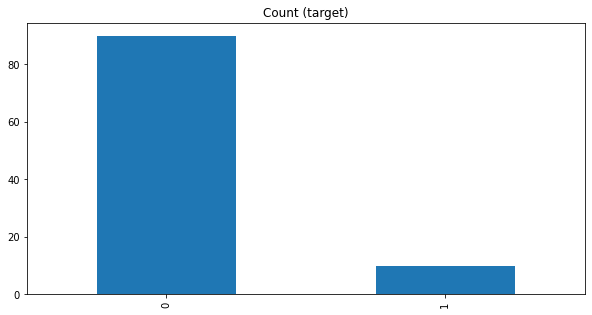

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.datasets import make_classification

plt.rcParams['figure.figsize'] = (10,5)

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=2, n_redundant=1, flip_y=0,
    n_features=5, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');

In [3]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

### Dimensionality Reduction

I will reduce the data dimensionality to just 2D, so we can easily plot it in a chart:

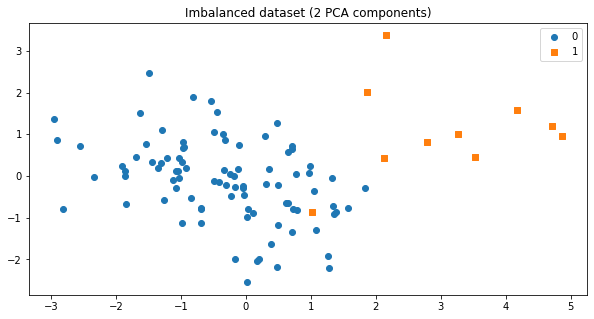

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

# Random Undersampling and Oversampling

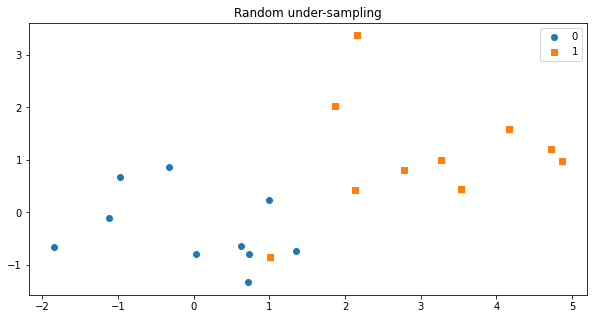

In [5]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

80 new random picked points


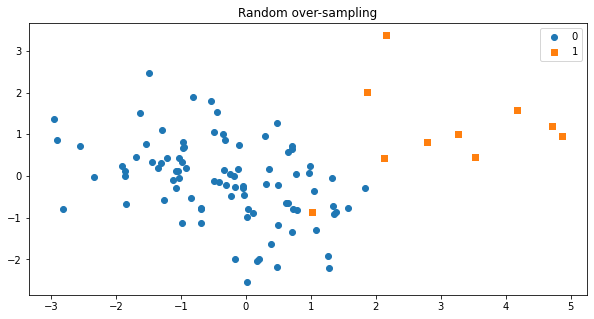

Cannot see the new points because they are "behind" the old orange ones... (they have the same value, they are just copied samples)


In [6]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')
print('Cannot see the new points because they are "behind" the old orange ones... (they have the same value, they are just copied samples)')

# Under-sampling: Tomek links

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

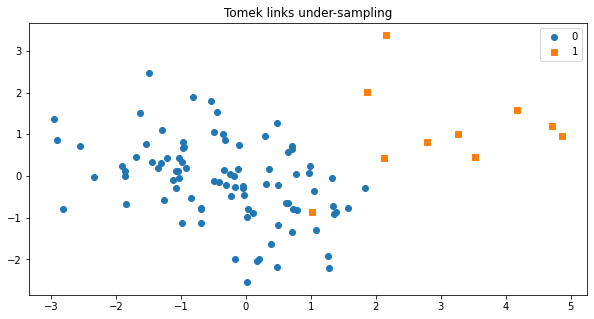

In [7]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X, y)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

# Under-sampling: Cluster Centroids

This technique performs under-sampling by generating centroids based on clustering methods. The data will be previously grouped by similarity, in order to preserve information.

In this example we will pass the {0: 10} dict for the parameter ratio, to preserve 10 elements from the majority class (0), and all minority class (1).

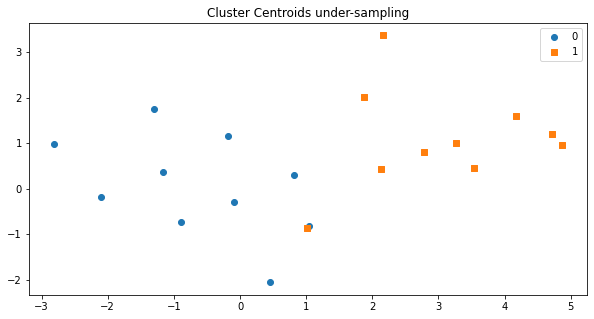

In [8]:
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import KMeans # We could use any other clustering method!!!

clustering_method = KMeans(n_clusters=2)

# We don't need to set the "estimator" parameter: By default it is KMeans already. Any sklearn clustering method is valid here.
cc = ClusterCentroids(sampling_strategy={0: 10}, estimator=clustering_method) 
X_cc, y_cc = cc.fit_resample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

# Over-sampling: SMOTE

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

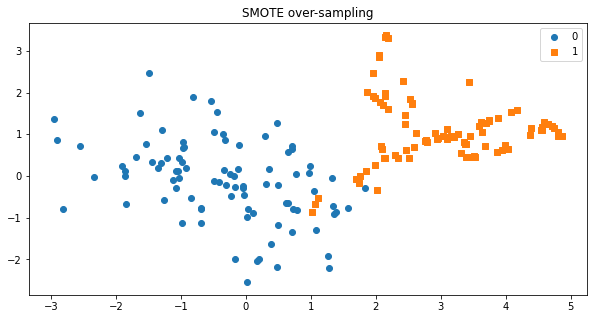

In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

# Over-sampling: ADASYN

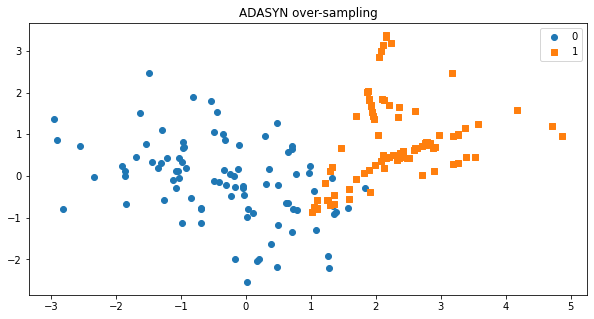

In [10]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(sampling_strategy='minority')
X_as, y_as = adasyn.fit_resample(X, y)

plot_2d_space(X_as, y_as, 'ADASYN over-sampling')

# Over-sampling followed by under-sampling

As mentioned in the slides, the most common usually is to apply both, to different degrees.

Many of them come already off-the-shelf. Now, we will do a combination of over-sampling and under-sampling, using the SMOTE and Tomek links techniques:

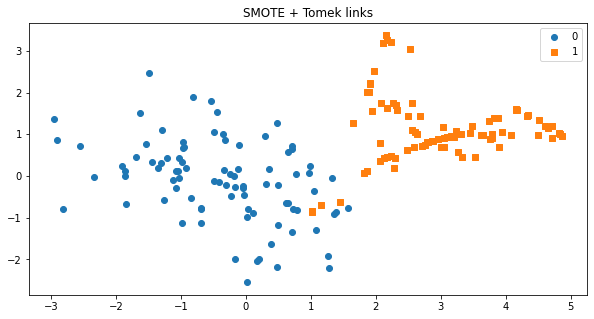

In [11]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='auto')
X_smt, y_smt = smt.fit_resample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

# Testing with Logistic Regression

We will now test all of the resampled data with a default Logistic Regression classifier:

In [12]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate

In [13]:
resamples = [
    ('original_pca', X, y),
    ('random_undersampling', X_rus, y_rus),
    ('random_oversampling', X_ros, y_ros),
    ('tomek_links', X_tl, y_tl),
    ('clustering_based', X_cc, y_cc),
    ('smote', X_sm, y_sm),
    ('adasyn', X_as, y_as),
    ('smote+tomek', X_smt, y_smt)
]
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

scores = []
for method, input_features, target in resamples:
    score = cross_validate(
        LogisticRegression(), input_features, target, cv=5, scoring=metrics
    )
    for s in score:
        score[s] = round(score[s].mean(), 6)
    score['method'] = method
    scores.append(score)

In [14]:
METRIC_TO_PLOT = 'test_f1'

methods = []
scores_to_plot = []
for s in scores:
    methods.append(s['method'])
    scores_to_plot.append(s[METRIC_TO_PLOT])

    
print('You can plot any of:',[k for k in scores[0].keys() if k != 'method'])

You can plot any of: ['fit_time', 'score_time', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']


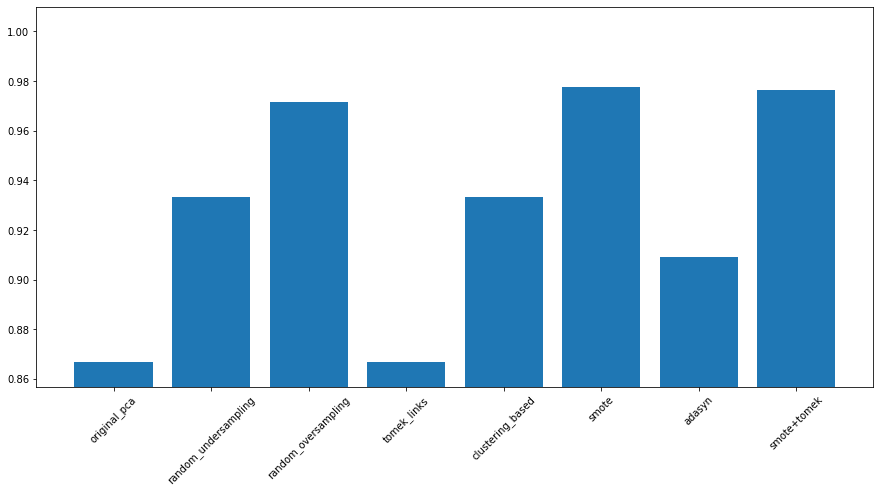

In [15]:
plt.rcParams['figure.figsize'] = (15,7)
plt.bar(methods, scores_to_plot)
plt.ylim((min(scores_to_plot)-0.01, 1.01))
plt.xticks(rotation=45)
plt.show()

The increase in F1-score performance with almost all resampling methods is overwhelming. Particularly, as expected, SMOTE is performing great - although a simple oversampling seems to be helping a lot too!


# Learning exercises:

* Are the results we got similar when we use other ML models instead of LogisticRegression? (e.g. SVM, RandomForest, KNN, Naive Bayes, AdaBoost, etc)
* Do these techniques always help, even with data with greater and greater imbalances?
* What happen when you apply these methods with a perfectly-balanced dataset?
* Try to create more classes, with different imbalanced ratios between them and apply resampling techniques to them. The `make_classifier` method is incredibly useful when we are researching classifiers' performance (e.g. if you are developing your own ensemble or some new classifier you might think of).